<h6><a href=\"javascript:toggle()\" target=\"_self\">Toggle source code</a></h6>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

In [2]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from scipy.spatial.distance import pdist
from scipy import stats

In [3]:
# Genes presence/absence matrix
# Made with Roary
roary = pd.read_table('../gene_presence_absence.csv',
                     sep=',',
                     low_memory=False)
# Set index (group name)
roary.set_index('Gene', inplace=True)
# Drop the other info columns
roary.drop(list(roary.columns[:10]), axis=1, inplace=True)

In [4]:
# Transform it in a presence/absence matrix (1/0)
roary.replace('.{2,100}', 1, regex=True, inplace=True)
roary.replace(np.nan, 0, regex=True, inplace=True)

In [5]:
# Read SNPs table
snps = pd.read_table('../SNPs_matrix.tsv')
snps.set_index(['position', 'alt'], inplace=True)

In [6]:
# Load the FDR corrections to identify proper phenotypes
a = pd.read_table('../emap.matrix.txt')
a.set_index('Gene', inplace=True)
# Load the FDR corrections to identify proper phenotypes
f = pd.read_table('../emap.fdr.txt')
f.set_index('Gene', inplace=True)

# Remove duplicate strains
# and dummy entries
remove = {x for x in a.index
          if '_1' in x
          or '_2' in x
          or '_3' in x
          or '_4' in x
          or 'dummy' in x.lower()}
a = a.drop(remove)
f = f.drop(remove)

In [7]:
# "Polish" the index
a.index = [a.index[i].split()[0] for i in range(len(a.index))]
f.index = [f.index[i].split()[0] for i in range(len(f.index))]

In [11]:
# Zero the missing values (maybe better to impute them?)
# a[np.isnan(a)] = 0

In [8]:
v = a[f < 0.05]

In [9]:
wt = 'NT12001'

In [15]:
phen_dist = {}
for other in v.index:
    if other == wt:
        continue
    d = v.loc[[wt, other]].copy(True)
    if d.shape[0] > 2:
        d = d.loc[d.index[:2]].copy(True)
    d[np.isnan(d)] = 0
    d[d > 0] = 1
    d[d < 0] = -1
#     d = d.T
#     phen_dist[other] = d[d[wt] > d[other]].shape[0]
    phen_dist[other] = pdist(d.as_matrix(), 'hamming')

In [16]:
snps_dist = {}
for other in snps.columns:
    if other == wt:
        continue
    d = snps[other].as_matrix()
    dwt = np.zeros(d.shape)
    snps_dist[other] = pdist(np.array([dwt, d]), 'hamming')

In [13]:
# snps_dist = {strain:x for strain, x in zip(snps.sum().index, snps.sum())}

In [17]:
# Get the accessory genome distance
wt = 'genome'
acc_dist = {}
for other in roary.columns:
    if other == wt:
        continue
    d = roary[[wt, other]]
#     acc_dist[other] = d[d[wt] != d[other]].shape[0]
    acc_dist[other] = pdist(d.T.as_matrix(), 'hamming')

In [18]:
pstrains = set(a.index)
gstrains = set(roary.columns)
vstrains = set(snps.columns)

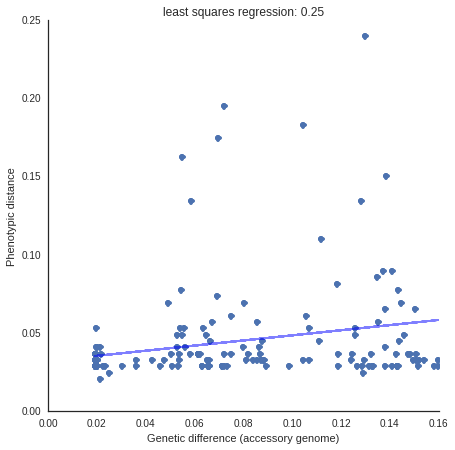

In [27]:
plt.figure(figsize=(7, 7))

acc_values = []
for strain, x in acc_dist.items():
    for strain1 in {k for k in phen_dist if strain.split('_')[0] == k}:
        if phen_dist[strain1].shape[0] > 1:
            value = phen_dist[strain1][0]
        else:
            value = phen_dist[strain1]
        acc_values.append((float(x), float(value)))

plt.plot([x[0] for x in acc_values],
         [x[1] for x in acc_values],
         'o')

slope, intercept, r_value, p_value, std_err = stats.linregress([x[0] for x in acc_values],
                                                               [x[1] for x in acc_values])
line = slope*np.array([x[0] for x in acc_values])+intercept
plt.plot([x[0] for x in acc_values],line,'b-', alpha=0.5)

plt.title('least squares regression: %.2f'%r_value)
plt.xlabel('Genetic difference (accessory genome)')
plt.ylabel('Phenotypic distance')

sns.despine()

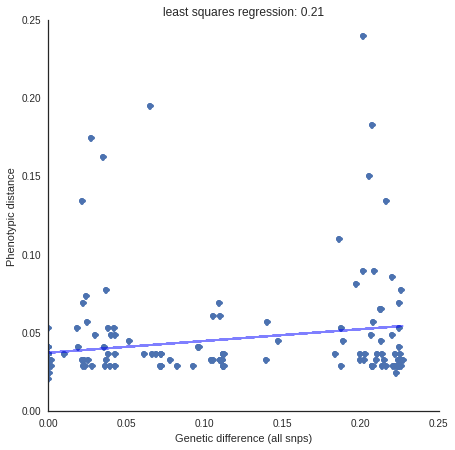

In [29]:
plt.figure(figsize=(7, 7))

snps_values = []
for strain, x in snps_dist.items():
    for strain1 in {k for k in phen_dist if strain.split('_')[0] == k}:
        if phen_dist[strain1].shape[0] > 1:
            value = phen_dist[strain1][0]
        else:
            value = phen_dist[strain1]
        snps_values.append((float(x), float(value)))

plt.plot([x[0] for x in snps_values],
         [x[1] for x in snps_values],
         'o')

slope, intercept, r_value, p_value, std_err = stats.linregress([x[0] for x in snps_values],
                                                               [x[1] for x in snps_values])
line = slope*np.array([x[0] for x in snps_values])+intercept
plt.plot([x[0] for x in snps_values],line,'b-', alpha=0.5)

plt.title('least squares regression: %.2f'%r_value)
plt.xlabel('Genetic difference (all snps)')
plt.ylabel('Phenotypic distance')

sns.despine()

In [30]:
max_acc = float(max([x[0] for x in acc_values]))
max_snps = float(max([x[0] for x in snps_values]))

In [32]:
values = []
for strain, x in snps_dist.items():
    for strain1 in {k for k in phen_dist if strain.split('_')[0] == k}:
        if phen_dist[strain1].shape[0] > 1:
            value = phen_dist[strain1][0]
        else:
            value = phen_dist[strain1]
        values.append((float(x), float(acc_dist[strain]), float(value)))

In [34]:
clf = linear_model.LinearRegression()
clf.fit(np.array([[x[0], x[1]] for x in values]),
        np.array([x[2] for x in values]))
pass

In [42]:
d = {'phenotype':[x[2] for x in values],
     'genotype':[(x[0]*clf.coef_[0] + x[1]*clf.coef_[1]) for x in values]}
d = pd.DataFrame(d)

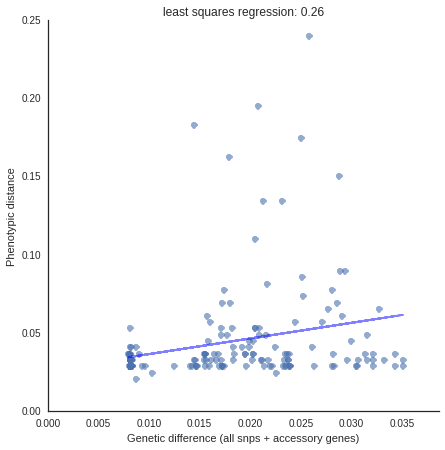

In [45]:
plt.figure(figsize=(7, 7))

vx = [x[0]*clf.coef_[0] + x[1]*clf.coef_[1] for x in values]
plt.plot(vx,
         [x[2] for x in values],
         'o',
         alpha=0.6)

slope, intercept, r_value, p_value, std_err = stats.linregress([x for x in vx],
                                                [x[2] for x in values])
line = slope*np.array(vx)+intercept
plt.plot(vx,line,'b-', alpha=0.5)

plt.title('least squares regression: %.2f'%r_value)
plt.xlabel('Genetic difference (all snps + accessory genes)')
plt.ylabel('Phenotypic distance')

plt.xlim(0, max(vx)+max(vx)*0.1)

sns.despine()

In [46]:
# Read deleterious SNPs table
snps = pd.read_table('../SNPs_del_matrix.tsv')
snps.set_index(['position', 'alt'], inplace=True)

In [47]:
snps_dist = {}
for other in snps.columns:
    d = snps[other].as_matrix()
    dwt = np.zeros(d.shape)
    snps_dist[other] = pdist(np.array([dwt, d]), 'hamming')[0]

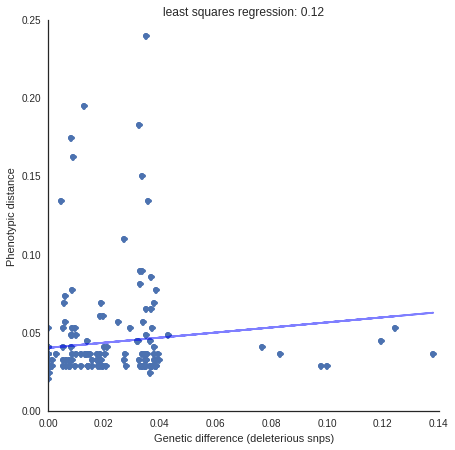

In [48]:
plt.figure(figsize=(7, 7))

snps_values = []
for strain, x in snps_dist.items():
    for strain1 in {k for k in phen_dist if strain.split('_')[0] == k}:
        if phen_dist[strain1].shape[0] > 1:
            value = phen_dist[strain1][0]
        else:
            value = phen_dist[strain1]
        snps_values.append((float(x), float(value)))

plt.plot([x[0] for x in snps_values],
         [x[1] for x in snps_values],
         'o')

slope, intercept, r_value, p_value, std_err = stats.linregress([x[0] for x in snps_values],
                                                               [x[1] for x in snps_values])
line = slope*np.array([x[0] for x in snps_values])+intercept
plt.plot([x[0] for x in snps_values],line,'b-', alpha=0.5)

plt.title('least squares regression: %.2f'%r_value)
plt.xlabel('Genetic difference (deleterious snps)')
plt.ylabel('Phenotypic distance')

sns.despine()

In [49]:
values = []
for strain, x in snps_dist.items():
    for strain1 in {k for k in phen_dist if strain.split('_')[0] == k}:
        if strain not in acc_dist:continue
        if phen_dist[strain1].shape[0] > 1:
            value = phen_dist[strain1][0]
        else:
            value = phen_dist[strain1]
        values.append((float(x), float(acc_dist[strain]), float(value)))

In [50]:
clf = linear_model.LinearRegression()
clf.fit(np.array([[x[0], x[1]] for x in values]),
        np.array([x[2] for x in values]))
pass

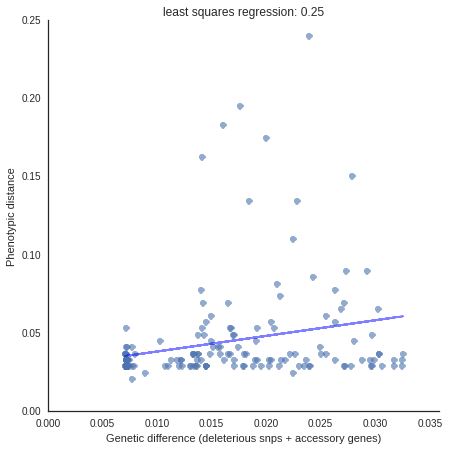

In [51]:
plt.figure(figsize=(7, 7))

vx = [x[0]*clf.coef_[0] + x[1]*clf.coef_[1] for x in values]
plt.plot(vx,
         [x[2] for x in values],
         'o',
         alpha=0.6)

slope, intercept, r_value, p_value, std_err = stats.linregress([x for x in vx],
                                                [x[2] for x in values])
line = slope*np.array(vx)+intercept
plt.plot(vx,line,'b-', alpha=0.5)

plt.title('least squares regression: %.2f'%r_value)
plt.xlabel('Genetic difference (deleterious snps + accessory genes)')
plt.ylabel('Phenotypic distance')

plt.xlim(0, max(vx)+max(vx)*0.1)

sns.despine()

In [52]:
# Read deleterious SNPs table
snps = pd.read_table('../SNPs_functional_matrix.tsv')
snps.set_index(['position', 'alt'], inplace=True)

In [53]:
snps_dist = {}
for other in snps.columns:
    d = snps[other].as_matrix()
    dwt = np.zeros(d.shape)
    snps_dist[other] = pdist(np.array([dwt, d]), 'hamming')[0]

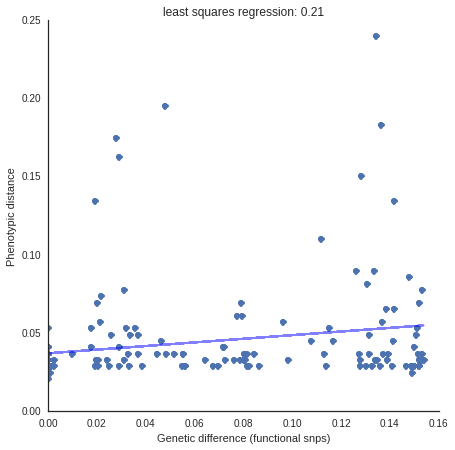

In [54]:
plt.figure(figsize=(7, 7))

snps_values = []
for strain, x in snps_dist.items():
    for strain1 in {k for k in phen_dist if strain.split('_')[0] == k}:
        if phen_dist[strain1].shape[0] > 1:
            value = phen_dist[strain1][0]
        else:
            value = phen_dist[strain1]
        snps_values.append((float(x), float(value)))

plt.plot([x[0] for x in snps_values],
         [x[1] for x in snps_values],
         'o')

slope, intercept, r_value, p_value, std_err = stats.linregress([x[0] for x in snps_values],
                                                               [x[1] for x in snps_values])
line = slope*np.array([x[0] for x in snps_values])+intercept
plt.plot([x[0] for x in snps_values],line,'b-', alpha=0.5)

plt.title('least squares regression: %.2f'%r_value)
plt.xlabel('Genetic difference (functional snps)')
plt.ylabel('Phenotypic distance')

sns.despine()

In [55]:
values = []
for strain, x in snps_dist.items():
    for strain1 in {k for k in phen_dist if strain.split('_')[0] == k}:
        if strain not in acc_dist:continue
        if phen_dist[strain1].shape[0] > 1:
            value = phen_dist[strain1][0]
        else:
            value = phen_dist[strain1]
        values.append((float(x), float(acc_dist[strain]), float(value)))

In [56]:
clf = linear_model.LinearRegression()
clf.fit(np.array([[x[0], x[1]] for x in values]),
        np.array([x[2] for x in values]))
pass

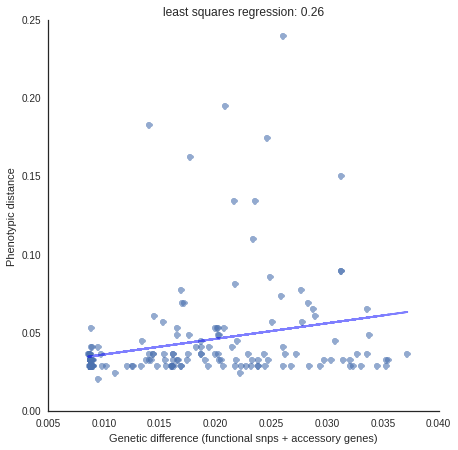

In [57]:
plt.figure(figsize=(7, 7))

vx = [x[0]*clf.coef_[0] + x[1]*clf.coef_[1] for x in values]
plt.plot(vx,
         [x[2] for x in values],
         'o',
         alpha=0.6)

slope, intercept, r_value, p_value, std_err = stats.linregress([x for x in vx],
                                                [x[2] for x in values])
line = slope*np.array(vx)+intercept
plt.plot(vx,line,'b-', alpha=0.5)

plt.title('least squares regression: %.2f'%r_value)
plt.xlabel('Genetic difference (functional snps + accessory genes)')
plt.ylabel('Phenotypic distance')

#plt.xlim(0, max(vx)+max(vx)*0.1)

sns.despine()